In [1]:
"""
n-gramのneural language modelで学習と予測を行うプログラム
"""

import torch
import torch.nn as nn
import torch.optim as optim


class NLM(nn.Module):
    """
    n-gram neural language model
    """

    def __init__(self, context_size, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear_W = nn.Linear(context_size*embedding_dim, hidden_dim)
        self.linear_U = nn.Linear(hidden_dim, vocab_size)

    def forward(self, context_word_ids):
        # shape: (1, context_size*embedding_dim)
        projection_layer = self.embedding(context_word_ids).view(1, -1)
        # shape: (1, hidden_dim)
        hidden_layer = torch.relu(self.linear_W(projection_layer))
        # shape: (1, vocab_size)
        output_layer = self.linear_U(hidden_layer)
        # shape: (1, vocab_size)
        return torch.log_softmax(output_layer, dim=1)


def build_vocab(sentences):
    all_tokens = []
    for s in sentences:
        all_tokens += s.split()
    vocab = set(all_tokens)
    token_to_index = dict(zip(vocab, range(len(vocab))))
    index_to_token = {index: token for token, index in token_to_index.items()}
    return token_to_index, index_to_token


def get_ngram_data(context_size, sentences, token_to_index):
    contexts, targets = [], []
    for s in sentences:
        tokens = s.split()
        for i in range(len(tokens)):
            if i+context_size == len(tokens):
                break
            context, target = tokens[i:i+context_size], tokens[i+context_size]
            context = torch.tensor(
                [token_to_index[w] for w in context], dtype=torch.long)
            target = torch.tensor(
                [token_to_index[target]], dtype=torch.long)
            contexts.append(context)
            targets.append(target)
    return contexts, targets

In [2]:
sentences = [
    "I have to make sure when I get home to foo the cat .",
    "I have to make foo when I get home to feed the cat .",
    "I have to make sure when you get home to feed the cat .",
    "I have to make sure when I get house to feed the dog ."]

token_to_index, index_to_token = build_vocab(sentences)
ngram_size = 4
context_size = ngram_size - 1
contexts, targets = get_ngram_data(context_size, sentences, token_to_index)

print(token_to_index)
print(index_to_token)
print(contexts[0])
print(targets[0])

{'feed': 0, 'have': 1, 'the': 2, 'sure': 3, 'house': 4, 'you': 5, '.': 6, 'home': 7, 'when': 8, 'get': 9, 'to': 10, 'cat': 11, 'I': 12, 'make': 13, 'foo': 14, 'dog': 15}
{0: 'feed', 1: 'have', 2: 'the', 3: 'sure', 4: 'house', 5: 'you', 6: '.', 7: 'home', 8: 'when', 9: 'get', 10: 'to', 11: 'cat', 12: 'I', 13: 'make', 14: 'foo', 15: 'dog'}
tensor([12,  1, 10])
tensor([13])


In [3]:
import numpy as np
model = NLM(
    context_size=context_size, vocab_size=len(token_to_index),
    embedding_dim=32, hidden_dim=32)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 30

# training
losses = []
for _ in range(num_epochs):
    epoch_loss = 0.
    # online SGD
    for _ in range(len(contexts)):
        r = np.random.randint(len(contexts))
        context = contexts[r]
        target = targets[r]
        optimizer.zero_grad()
        log_prob = model(context)
        loss = criterion(log_prob, target)
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    losses.append(epoch_loss)

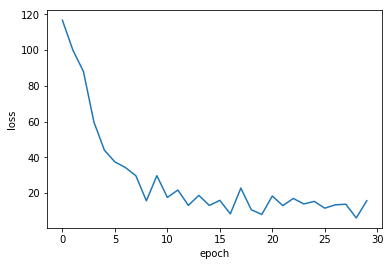

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses)

In [5]:
print('corpus sentences:')
for s in sentences:
    print(s)
print()

# predict
context_words = ['I', 'have', 'to']
assert len(context_words) == context_size
predicted_tokens = context_words.copy()
while True:
    context_tensor = torch.tensor([token_to_index[w] for w in context_words])
    predicted_log_prob = model(context_tensor)
    next_word_index = torch.argmax(predicted_log_prob).item()
    next_word = index_to_token[next_word_index]
    predicted_tokens.append(next_word)
    if next_word == '.':
        break
    context_words.pop(0)
    context_words.append(next_word)

# 最も尤度が大きい文を生成できている
print(' '.join(predicted_tokens))

corpus sentences:
I have to make sure when I get home to foo the cat .
I have to make foo when I get home to feed the cat .
I have to make sure when you get home to feed the cat .
I have to make sure when I get house to feed the dog .

I have to make foo when I get home to feed the cat .


In [6]:
# 'I have foo'はコーパスに出現しないが、P(w | I have foo)はゼロにならない
# つまりsmoothingの必要がない
# 'make' = argmax P(w | I have foo)となり、妥当な結果といえる

context_words = ['I', 'have', 'foo']
context_tensor = torch.tensor([token_to_index[w] for w in context_words])
predicted_log_prob = model(context_tensor)
print(predicted_log_prob)
next_word_index = torch.argmax(predicted_log_prob).item()
next_word = index_to_token[next_word_index]
print(next_word)

tensor([[-6.6579, -8.4844, -5.7965, -5.5818, -7.9828, -7.5240, -7.6639, -7.4778,
         -4.4591, -8.4202, -4.2707, -7.2909, -7.3694, -0.0589, -3.9298, -8.1141]],
       grad_fn=<LogSoftmaxBackward>)
make
